In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real
RANDOM_STATE = 2005
np.random.seed(RANDOM_STATE)

In [2]:
personality = pd.read_csv("personality.csv")
heart = pd.read_csv("heart.csv")
loan = pd.read_csv("loan.csv")
machine = pd.read_csv("machine.csv")

# Usuwamy zbędne kolumny z zestawu danych loan: name (z jasnych przyczyn), city (z powodu 1882 unikalnych wartości) 
# i points (bo bezpośrednio zdradza nam czy otrzymano kredyt >60).
loan = loan.drop(columns=['name', 'city', 'points'])
personality = personality.rename(columns={'Personality': 'Introverted'})

datasets = {
    "Personality": personality,
    "Heart": heart,
    "Loan": loan,
    "Machine": machine
}

In [3]:
def prepare_data(df):
    df = df.copy().dropna()
    
    binary_map = {"Yes": 1, "No": 0, True: 1, False: 0, "Introvert": 1, "Extrovert": 0}
    df = df.replace(binary_map)
    df = pd.get_dummies(df, drop_first=False)
    
    known_targets = ["HeartDisease", "loan_approved", "Introverted", "fail"]
    target_col = next(col for col in df.columns if col in known_targets)
    y = df[target_col]
    X = df.drop(columns=[target_col])
    X = X.astype(float)
    y = y.astype(int)

    print(f"\n Dane po przygotowaniu ({target_col}):")
    print("X shape:", X.shape, "| y shape:", y.shape)
    print("y value counts:", dict(pd.Series(y).value_counts()))
    print(X.head(3))
    print(y.head(3))

    return train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)


param_grid_unif = { # do GridSearchCV i RandomizedSearchCV z rozkładem jednostajnym
    'svc__C': [0.1, 1, 10, 100, 1000, 10000, 100000],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

param_space_bs = {  # do BayesSearchCV
    'svc__C': Real(1e-1, 1e5, prior='log-uniform'),
    'svc__gamma': Real(1e-4, 1, prior='log-uniform')
}

In [18]:
def tune_and_evaluate(name, df):
    print(f"\nDataset: {name}")
    X_train, X_test, y_train, y_test = prepare_data(df)
    print(X_train.shape[1])
    print(np.var(X_train.values))
    print(f"Sugerowane gamma: {1 / (X_train.shape[1] * np.var(X_train.values))}")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='rbf', class_weight='balanced'))
    ])

    f1 = make_scorer(f1_score)
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid_unif,
        scoring=f1,
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    y_pred_gs = grid_search.predict(X_test)
    f1_gs = f1_score(y_test, y_pred_gs)

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid_unif,
        n_iter=35,
        scoring=f1,
        cv=5,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    )
    random_search.fit(X_train, y_train)
    y_pred_rs = random_search.predict(X_test)
    f1_rs = f1_score(y_test, y_pred_rs)

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space_bs,
        n_iter=35,
        scoring=f1,
        cv=5,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    )
    bayes_search.fit(X_train, y_train)
    y_pred_bs = bayes_search.predict(X_test)
    f1_bs = f1_score(y_test, y_pred_bs)

    results = {
        "Dataset": name,
        "F1_GridSearch": f1_gs,
        "BestParams_GS": grid_search.best_params_,
        "F1_RandomSearch": f1_rs,
        "BestParams_RS": random_search.best_params_,
        "F1_BayesSearch": f1_bs,
        "BestParams_BS": bayes_search.best_params_
    }

    return results, grid_search.cv_results_, bayes_search.cv_results_, random_search.cv_results_

In [19]:
all_results = []
cv_grid, cv_bayes, cv_random = {}, {}, {}

for name, df in datasets.items():
    res, cv_gs, cv_bs, cv_rs = tune_and_evaluate(name, df)
    all_results.append(res)
    cv_grid[name] = cv_gs
    cv_bayes[name] = cv_bs
    cv_random[name] = cv_rs

results_df = pd.DataFrame(all_results)
display(results_df)


Dataset: Personality

 Dane po przygotowaniu (Introverted):
X shape: (2900, 7) | y shape: (2900,)
y value counts: {0: np.int64(1491), 1: np.int64(1409)}
   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         0.0                      4.0            6.0   
1               9.0         1.0                      0.0            0.0   
2               9.0         1.0                      1.0            2.0   

   Drained_after_socializing  Friends_circle_size  Post_frequency  
0                        0.0                 13.0             5.0  
1                        1.0                  0.0             3.0  
2                        1.0                  5.0             2.0  
0    0
1    1
2    1
Name: Introverted, dtype: int64
7
11.107902690717621
Sugerowane gamma: 0.0128608565302361


/tmp/ipykernel_6184/1168481550.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)



Dataset: Heart

 Dane po przygotowaniu (HeartDisease):
X shape: (918, 20) | y shape: (918,)
y value counts: {1: np.int64(508), 0: np.int64(410)}
    Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_F  Sex_M  \
0  40.0      140.0        289.0        0.0  172.0      0.0    0.0    1.0   
1  49.0      160.0        180.0        0.0  156.0      1.0    1.0    0.0   
2  37.0      130.0        283.0        0.0   98.0      0.0    0.0    1.0   

   ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0                0.0                1.0                0.0               0.0   
1                0.0                0.0                1.0               0.0   
2                0.0                1.0                0.0               0.0   

   RestingECG_LVH  RestingECG_Normal  RestingECG_ST  ExerciseAngina_N  \
0             0.0                1.0            0.0               1.0   
1             0.0                1.0            0.0               1.0   
2        

/tmp/ipykernel_6184/1168481550.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)



Dataset: Machine

 Dane po przygotowaniu (fail):
X shape: (944, 9) | y shape: (944,)
y value counts: {0: np.int64(551), 1: np.int64(393)}
   footfall  tempMode   AQ  USS   CS  VOC    RP   IP  Temperature
0       0.0       7.0  7.0  1.0  6.0  6.0  36.0  3.0          1.0
1     190.0       1.0  3.0  3.0  5.0  1.0  20.0  4.0          1.0
2      31.0       7.0  2.0  2.0  6.0  1.0  24.0  6.0          1.0
0    1
1    0
2    0
Name: fail, dtype: int64
9
104650.13466004035
Sugerowane gamma: 1.0617388259657714e-06


,Dataset,F1_GridSearch,BestParams_GS,F1_RandomSearch,BestParams_RS,F1_BayesSearch,BestParams_BS
0,Personality,0.936620,"{'svc__C': 0.1, 'svc__gamma': 0.001}",0.936620,"{'svc__gamma': 0.001, 'svc__C': 0.1}",0.935370,"{'svc__C': 4.639350988215665, 'svc__gamma': 0...."
1,Heart,0.894040,"{'svc__C': 1, 'svc__gamma': 0.1}",0.894040,"{'svc__gamma': 0.1, 'svc__C': 1}",0.888136,"{'svc__C': 11.034974681202195, 'svc__gamma': 0..."
2,Loan,0.944238,"{'svc__C': 1, 'svc__gamma': 1}",0.944238,"{'svc__gamma': 1, 'svc__C': 1}",0.953445,"{'svc__C': 1.3848726730241583, 'svc__gamma': 1.0}"
3,Machine,0.868852,"{'svc__C': 10, 'svc__gamma': 0.01}",0.868852,"{'svc__gamma': 0.01, 'svc__C': 10}",0.863071,"{'svc__C': 64.38333368096684, 'svc__gamma': 0...."


In [20]:
def extract_trials_from_cv_results(cv_results):
    params_list = cv_results.get('params')
    mean_scores = cv_results.get('mean_test_score')
    trials = []
    for p, s in zip(params_list, mean_scores):
        trials.append((p, float(s)))
    return trials

history = {"grid": {}, "bayes": {}, "random": {}}

for name in datasets.keys():
    trials = extract_trials_from_cv_results(cv_grid[name])
    history["grid"][name] = trials
    trials = extract_trials_from_cv_results(cv_bayes[name])
    history["bayes"][name] = trials
    trials = extract_trials_from_cv_results(cv_random[name])
    history["random"][name] = trials

print(history)

{'grid': {'Personality': [({'svc__C': 0.1, 'svc__gamma': 0.0001}, 0.13112582781456955), ({'svc__C': 0.1, 'svc__gamma': 0.001}, 0.9319121352002838), ({'svc__C': 0.1, 'svc__gamma': 0.01}, 0.9319121352002838), ({'svc__C': 0.1, 'svc__gamma': 0.1}, 0.9319121352002838), ({'svc__C': 0.1, 'svc__gamma': 1}, 0.9319121352002838), ({'svc__C': 1, 'svc__gamma': 0.0001}, 0.9319121352002838), ({'svc__C': 1, 'svc__gamma': 0.001}, 0.9319121352002838), ({'svc__C': 1, 'svc__gamma': 0.01}, 0.9319121352002838), ({'svc__C': 1, 'svc__gamma': 0.1}, 0.9319121352002838), ({'svc__C': 1, 'svc__gamma': 1}, 0.9319121352002838), ({'svc__C': 10, 'svc__gamma': 0.0001}, 0.9319121352002838), ({'svc__C': 10, 'svc__gamma': 0.001}, 0.9178028204753073), ({'svc__C': 10, 'svc__gamma': 0.01}, 0.9319121352002838), ({'svc__C': 10, 'svc__gamma': 0.1}, 0.9319121352002838), ({'svc__C': 10, 'svc__gamma': 1}, 0.9293166843869691), ({'svc__C': 100, 'svc__gamma': 0.0001}, 0.9178028204753073), ({'svc__C': 100, 'svc__gamma': 0.001}, 0.9178

In [37]:
def summarize_param_results(history_subset):
    """
    Oblicza średni i wariancję F1-score dla każdej pary (C, gamma) na podstawie wyników ze wszystkich zbiorów danych.
    """
    combos = set()
    for trials in history_subset.values():
        for params, _ in trials:
            combos.add((params['svc__C'], params['svc__gamma']))

    results = []
    for C, gamma in combos:
        scores = []
        for _ , trials in history_subset.items():
            for params, f1 in trials:
                if params['svc__C'] == C and params['svc__gamma'] == gamma:
                    scores.append(f1)
                    break
        print(scores)
        results.append({
            'svc__C': C,
            'svc__gamma': gamma,
            'mean_f1': np.mean(scores),
            'var_f1': np.var(scores)
        })

    return pd.DataFrame(results)


In [46]:
summary_grid = summarize_param_results(history["grid"])
summary_bayes = summarize_param_results(history["bayes"])
summary_random = summarize_param_results(history["random"])

best_row = summary_grid.loc[summary_grid['mean_f1'].idxmax()]

new_default = {'svc__C': best_row['svc__C'], 'svc__gamma': best_row['svc__gamma']}
f1_default = best_row['mean_f1']

print("\nNowy domyślny zestaw hiperparametrów (średnio najlepszy ze wszystkich zbiorów danych):")
for k, v in new_default.items():
    print(f"{k}: {v}")

print(f"\nŚredni wynik F1 dla tej konfiguracji: {f1_default:.4f}")

[0.9293240265026039, 0.8402488273927918, 0.9484124200234669, 0.8380837471338891]
[0.8675992834610347, 0.7844072892242687, 0.9489732973642637, 0.8214611513176469]
[0.9319121352002838, 0.83529826847424, 0.9528937249153057, 0.8514944054520139]
[0.9036522035770075, 0.8402488273927918, 0.942151828807666, 0.8380837471338891]
[0.8957559989071194, 0.7844072892242687, 0.9489732973642637, 0.8214611513176469]
[0.9319121352002838, 0.8402488273927918, 0.9517727095775144, 0.8380837471338891]
[0.9319121352002838, 0.8583989847698126, 0.8899399671425176, 0.8964605936498342]
[0.8659640059640059, 0.7844072892242687, 0.9489732973642637, 0.8214611513176469]
[0.9319121352002838, 0.8644180960055255, 0.909364464650482, 0.9049520799445837]
[0.9319121352002838, 0.8647010284772854, 0.8939269759757218, 0.9048126727809196]
[0.9319121352002838, 0.48904096992332285, 0.0, 0.0]
[0.9319121352002838, 0.8227230429130079, 0.9356992227785422, 0.8596331698665871]
[0.9178028204753073, 0.859776248696577, 0.8928437443379819, 0

In [23]:
def plot_f1_scatter(summary_df, title_prefix):
    """
    Rysuje dwa wykresy scatter:
    1. Średni F1-score dla każdej pary (C, gamma)
    2. Wariancję F1-score między zbiorami danych
    """
    _ , axes = plt.subplots(1, 2, figsize=(14, 5))

    # ŚREDNI F1
    sc1 = axes[0].scatter(
        summary_df['svc__C'],
        summary_df['svc__gamma'],
        c=summary_df['mean_f1'],
        cmap='coolwarm',
        s=100,
        edgecolor='k'
    )
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('C')
    axes[0].set_ylabel('gamma')
    axes[0].set_title(f'{title_prefix}: średni F1')
    plt.colorbar(sc1, ax=axes[0])

    # WARIANCJA F1
    sc2 = axes[1].scatter(
        summary_df['svc__C'],
        summary_df['svc__gamma'],
        c=summary_df['var_f1'],
        cmap='viridis',
        s=100,
        edgecolor='k'
    )
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_xlabel('C')
    axes[1].set_ylabel('gamma')
    axes[1].set_title(f'{title_prefix}: wariancja F1 między zbiorami')
    plt.colorbar(sc2, ax=axes[1])

    plt.tight_layout()
    plt.show()

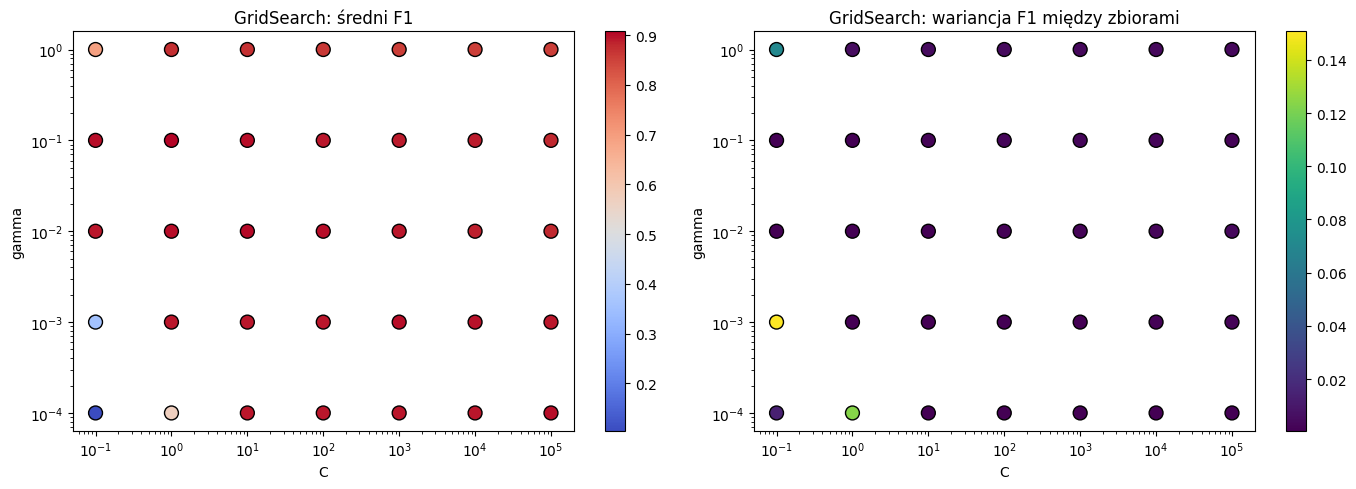

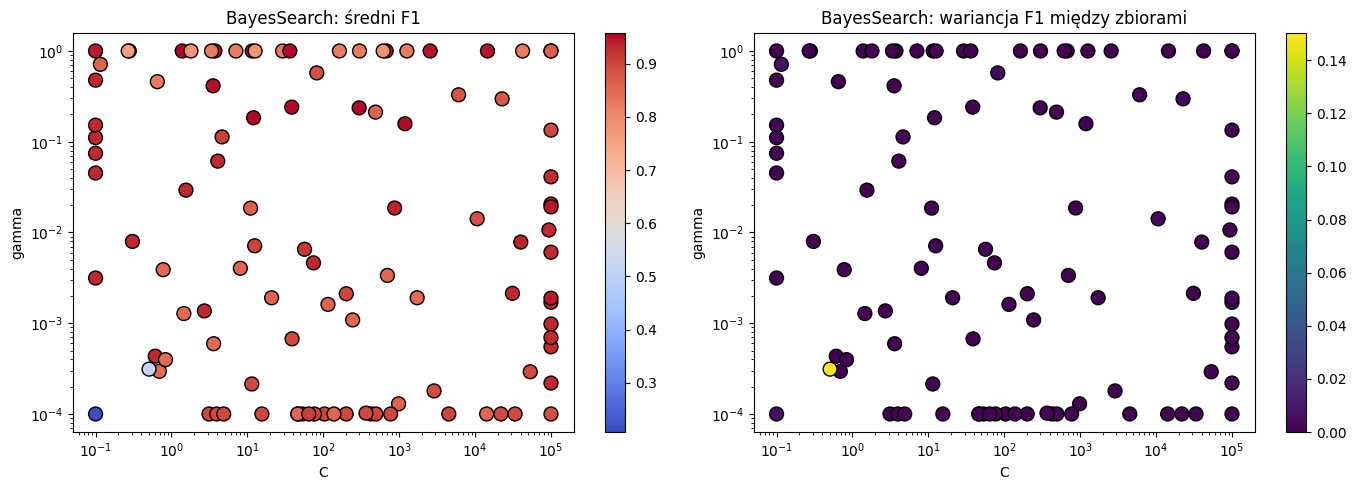

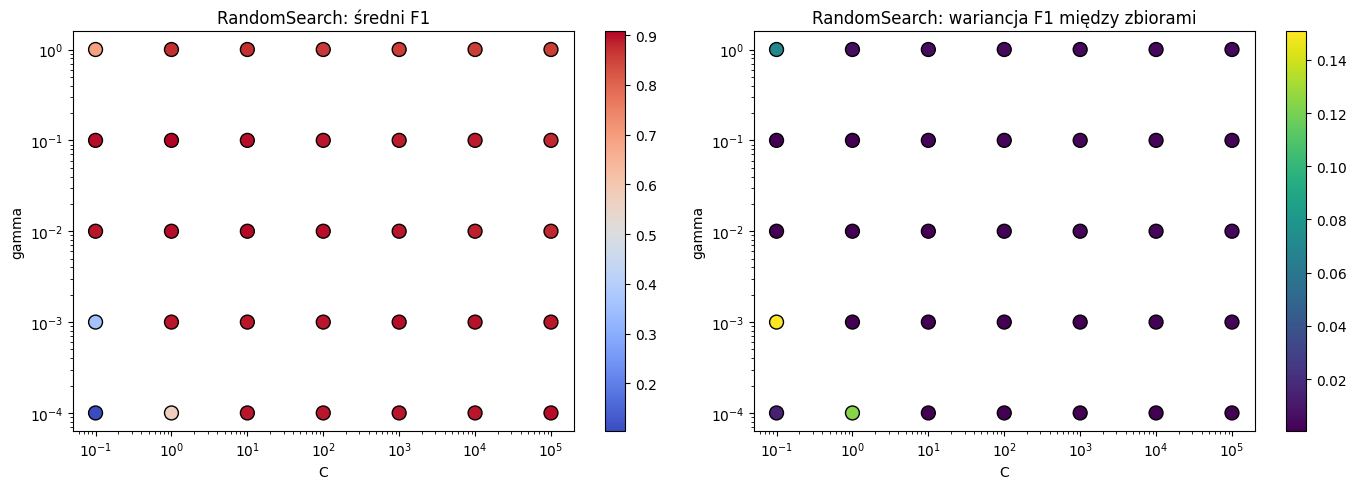

In [24]:
plot_f1_scatter(summary_grid, "GridSearch")
plot_f1_scatter(summary_bayes, "BayesSearch")
plot_f1_scatter(summary_random, "RandomSearch")

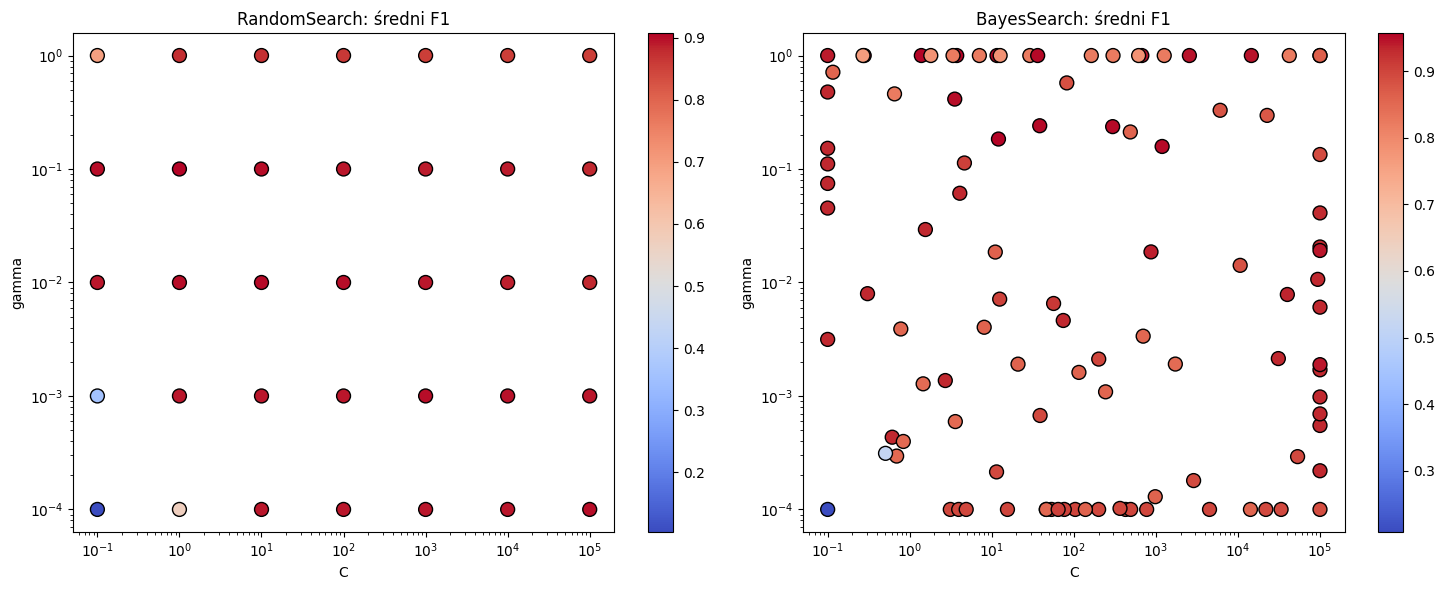

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sc1 = axes[0].scatter(
    summary_random['svc__C'],
    summary_random['svc__gamma'],
    c=summary_random['mean_f1'],
    cmap='coolwarm',
    s=100,
    edgecolor='k'
)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('C')
axes[0].set_ylabel('gamma')
axes[0].set_title('RandomSearch: średni F1')
plt.colorbar(sc1, ax=axes[0])

sc2 = axes[1].scatter(
    summary_bayes['svc__C'],
    summary_bayes['svc__gamma'],
    c=summary_bayes['mean_f1'],
    cmap='coolwarm',
    s=100,
    edgecolor='k'
)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('C')
axes[1].set_ylabel('gamma')
axes[1].set_title('BayesSearch: średni F1')
plt.colorbar(sc2, ax=axes[1])

plt.tight_layout()
plt.show()

In [25]:
def find_default_f1(dataset_name, new_default):
    if best_row_grid['mean_f1'] >= best_row_random['mean_f1']:
        trials = history["grid"][dataset_name]
    else:
        trials = history["random"][dataset_name]
    for params, f1 in trials:
            if params['svc__C'] == new_default['svc__C'] and params['svc__gamma'] == new_default['svc__gamma']:
                default_f1 = f1
    return default_f1

def compute_f1_differences(history_subset, new_default):
    diffs = []
    for dataset_name, trials in history_subset.items():
        default_f1 = find_default_f1(dataset_name, new_default)
        for params, f1 in trials:
            diff = f1 - default_f1
            diffs.append({
                'dataset': dataset_name,
                'svc__C': params['svc__C'],
                'svc__gamma': params['svc__gamma'],
                'f1_diff': diff
            })
    return pd.DataFrame(diffs)


         dataset    svc__C  svc__gamma   f1_diff
0    Personality       0.1      0.0001 -0.800786
1    Personality       0.1      0.0010  0.000000
2    Personality       0.1      0.0100  0.000000
3    Personality       0.1      0.1000  0.000000
4    Personality       0.1      1.0000  0.000000
..           ...       ...         ...       ...
135      Machine  100000.0      0.0001 -0.001067
136      Machine  100000.0      0.0010 -0.024785
137      Machine  100000.0      0.0100 -0.064590
138      Machine  100000.0      0.1000 -0.061311
139      Machine  100000.0      1.0000 -0.077934

[140 rows x 4 columns]
         dataset         svc__C  svc__gamma   f1_diff
0    Personality   22679.014906    0.296766 -0.061525
1    Personality       4.639351    0.113005  0.000000
2    Personality   53324.189504    0.000292  0.000000
3    Personality       0.115759    0.712879  0.000000
4    Personality      82.100956    0.573664 -0.006595
..           ...            ...         ...       ...
135      M

/tmp/ipykernel_6184/2135080693.py:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


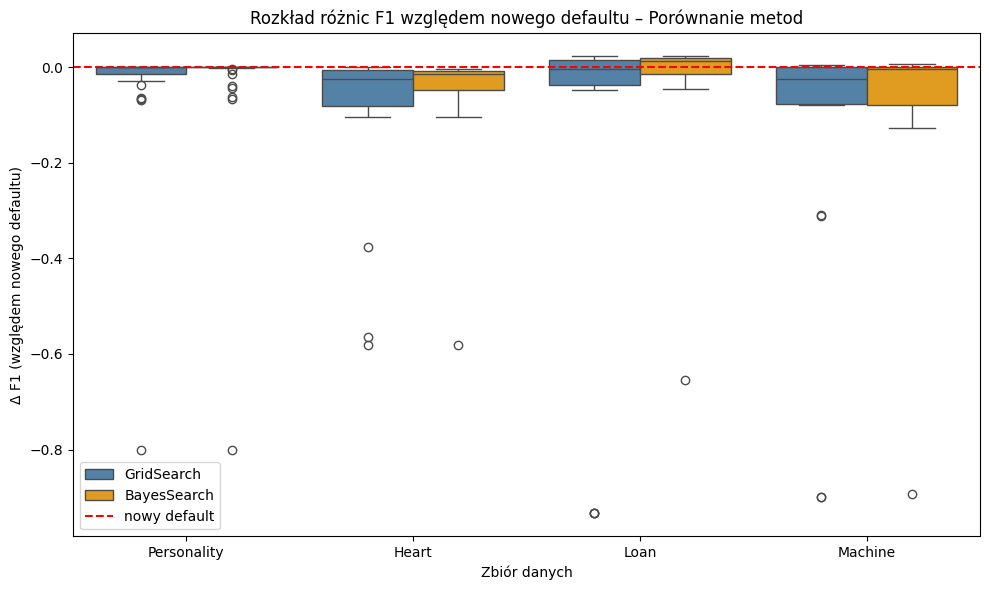

In [48]:
diffs_grid = compute_f1_differences(history["grid"], new_default)
diffs_bayes = compute_f1_differences(history["bayes"], new_default)
diffs_random = compute_f1_differences(history["random"], new_default)
print(diffs_grid)
print(diffs_bayes)
print(diffs_random)

diffs_grid["method"] = "GridSearch"
diffs_bayes["method"] = "BayesSearch"
#diffs_random["method"] = "RandomSearch"
diffs_all = pd.concat([diffs_grid, diffs_bayes], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=diffs_all,
    x="dataset",
    y="f1_diff",
    hue="method",
    palette=["steelblue", "orange", "green"]
)
plt.axhline(0, color='red', linestyle='--', label="nowy default")
plt.title("Rozkład różnic F1 względem nowego defaultu – Porównanie metod")
plt.xlabel("Zbiór danych")
plt.ylabel("Δ F1 (względem nowego defaultu)")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
def compute_tunability(history_subset, new_default):
    """
    Oblicza tunowalność dla każdego zbioru danych w danej metodzie tunowania.
    """
    results = []
    for dataset_name, trials in history_subset.items():
        best_f1 = max([f1 for _, f1 in trials])
        default_f1 = find_default_f1(dataset_name, new_default)
        results.append({
            'dataset': dataset_name,
            'best_f1': best_f1,
            'default_f1': default_f1,
            'tunability': best_f1 - default_f1
        })

    return pd.DataFrame(results)

tunability_grid = compute_tunability(history["grid"], new_default)
tunability_bayes = compute_tunability(history["bayes"], new_default)
tunability_random = compute_tunability(history["random"], new_default)

tunability_grid["method"] = "GridSearch"
tunability_bayes["method"] = "BayesSearch"
tunability_random["method"] = "RandomSearch"
tunability_all = pd.concat([tunability_grid, tunability_bayes, tunability_random])

display(tunability_all)


,dataset,best_f1,default_f1,tunability,method
0,Personality,0.931912,0.931912,0.000000,GridSearch
1,Heart,0.865508,0.865508,0.000000,GridSearch
2,Loan,0.957788,0.933607,0.024180,GridSearch
3,Machine,0.904952,0.899395,0.005557,GridSearch
0,Personality,0.931912,0.931912,0.000000,BayesSearch
1,Heart,0.862270,0.865508,-0.003238,BayesSearch
2,Loan,0.957841,0.933607,0.024233,BayesSearch
3,Machine,0.906771,0.899395,0.007375,BayesSearch
0,Personality,0.931912,0.931912,0.000000,RandomSearch
1,Heart,0.865508,0.865508,0.000000,RandomSearch


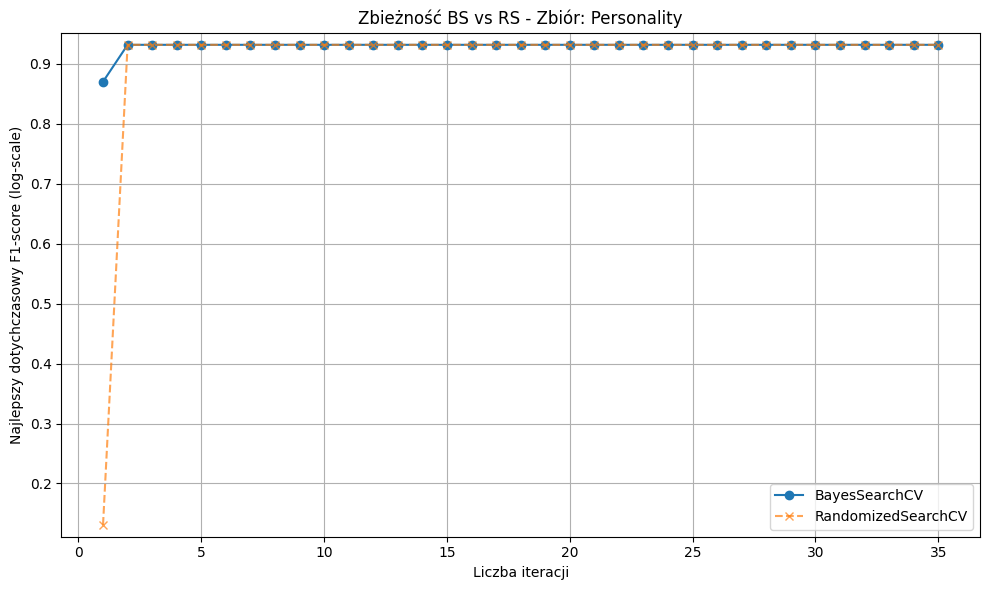

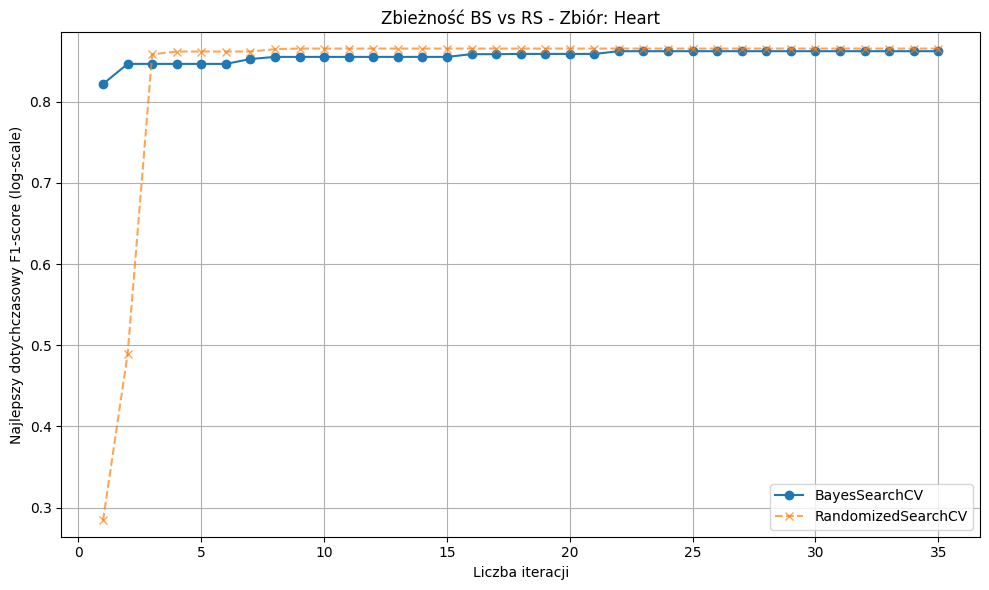

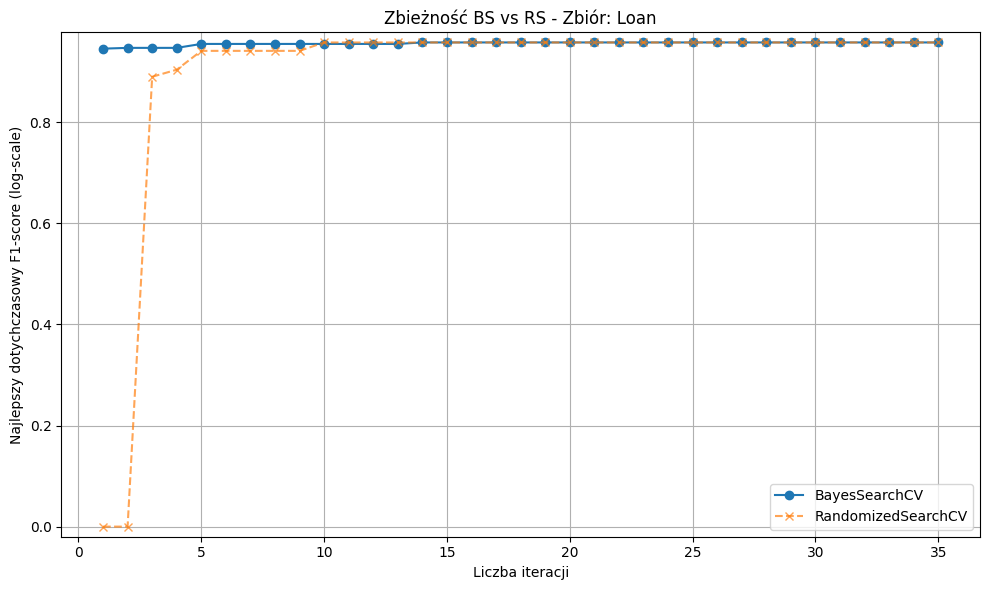

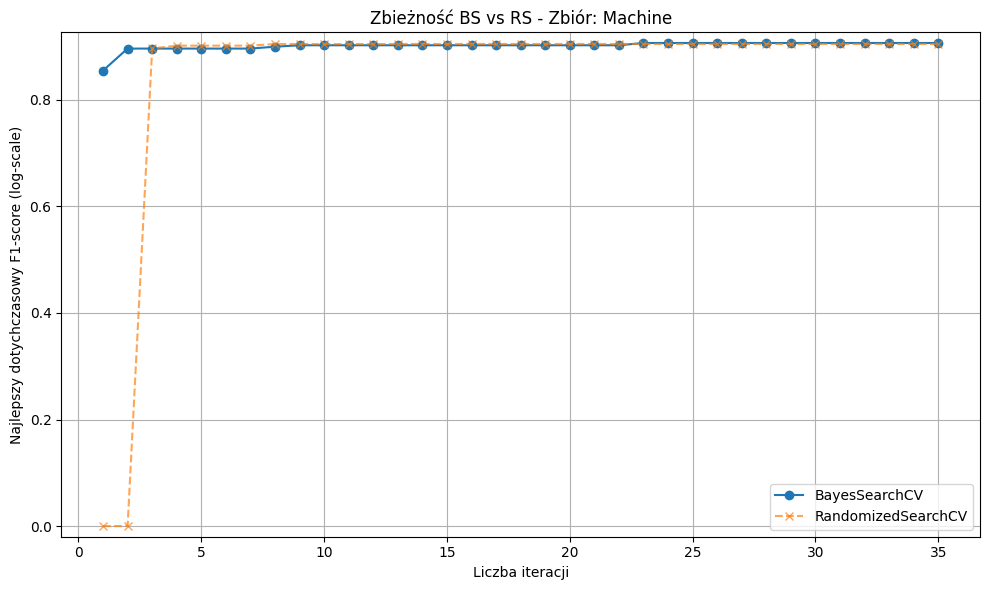

In [41]:
for name in datasets.keys():
    
    plt.figure(figsize=(10, 6))
    
    trials_bs = history["bayes"][name]
    scores_bs = [f1 for _, f1 in trials_bs]
    running_best_scores_bs = np.maximum.accumulate(scores_bs)
    
    trials_rs = history["random"][name]
    scores_rs = [f1 for _, f1 in trials_rs]
    running_best_scores_rs = np.maximum.accumulate(scores_rs)
    
    iterations = range(1, len(scores_bs) + 1)
    
    plt.plot(iterations, running_best_scores_bs, marker='o', linestyle='-', label='BayesSearchCV')
    plt.plot(iterations, running_best_scores_rs, marker='x', linestyle='--', label='RandomizedSearchCV', alpha=0.7)
    
    #plt.yscale('log')
    plt.title(f"Zbieżność BS vs RS - Zbiór: {name}")
    plt.xlabel("Liczba iteracji")
    plt.ylabel("Najlepszy dotychczasowy F1-score (log-scale)")
    plt.grid(True, which="both", ls="-")
    
    min_score = min(min(scores_bs), min(scores_rs))
    max_score = max(max(scores_bs), max(scores_rs))
    plt.ylim(bottom=min_score - 0.02, top=max_score + 0.02) 
    
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.close()